# Now we will load DESeq2 for differential expression analysis

You will first need to install DESeq2. This is a program that runs in R, so we need to install it within R. First, we will use conda to download R in our anaconda. If you check which R before installing it to conda, it might take you to a R installation that already exists on TSCC. Since we want to be in control of our specific version and installs, we will use anaconda to install it.

    conda install -c r r
    
There is an r-essentials packages that has a lot of the commonly used R packages available for install all in one! We will use conda to install that package too.

    conda install -c r r-essentials
    
In order to run DESeq2, we need to update a few other r packages (I found this out by trying to install DESeq2 and getting errors that it needs a newer version of these programs).

    conda install -c r r-xml
    
    conda install gcc

Open R in your terminal on TSCC by typing:

    R
    
This will now take you into R where you can do your installation. Note that your command line now has a > rather than your TSCC login. This is specific to the R language. Now you are coding in R, not BASH. Use the following two commands to install DESeq2:

    source("http://bioconductor.org/biocLite.R")
    
    biocLite("DESeq2")
    
It will ask you about updating packages:

    Update all/some/none? [a/s/n]: 
    
Type a to update all.

It might error out at the end saying that some packages had "Non-Zero Exit status." That is okay, move forward with the next command to see if you can load DESeq2.

    library("DESeq2")
    
It should load without any error messages. There will be a lot of other messages that come up with the package loading, but nothing that says error or failed. Great! Now that we know it installed properly, let's get out of R and go back to the bash terminal. To get back to a bash command line, quit R with:

    quit()
    
Do you want to save the workspace image? No.
    
Now when you open a jupyter notebook, you will have the option to select R as a kernel in a new notebook. Try it out! If you already have jupyter running, refresh your web browser (or refresh your notebook kernel) to activate these changes. 

In [2]:
suppressMessages(library("DESeq2"))

library("ggplot2")

library("RColorBrewer")

In [3]:
counts <- read.csv('/home/ucsd-train40/cmm262/deseq2/tardbp_counts_for_deseq2.csv',
                  header=TRUE, row.names=1)
head(counts)

,NT_shRNA_hepg2_Rep1,NT_shRNA_hepg2_Rep2,TARDBP_shRNA_hepg2_Rep1,TARDBP_shRNA_hepg2_Rep2
ENSG00000227232.4,61,92,69,58
ENSG00000237683.5,23,21,17,28
ENSG00000239906.1,11,2,5,7
ENSG00000241860.2,26,32,35,35
ENSG00000228463.4,77,69,63,66
ENSG00000237094.7,38,44,45,41


In [4]:
col_data <- read.csv('/home/ucsd-train40/cmm262/deseq2/tardbp_conditions_for_deseq2.csv',
                  header=TRUE, row.names=1)

head(col_data)

,condition
NT_shRNA_hepg2_Rep1,control
NT_shRNA_hepg2_Rep2,control
TARDBP_shRNA_hepg2_Rep1,knockdown
TARDBP_shRNA_hepg2_Rep2,knockdown


We are not going to take our counts matrix and format it in a way that can be read by DESeq2. The general precessing steps are detailed [here]("http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html"), but we will be just covering the basics

First, we will define experimental parameters. If using a counts matrix, we will use the following function, where countData is equal to our counts matrix ("counts"), colData is equal to our conditions, and design accounts for how we wish to model our effect (in this case, by the "condition" or treatment with a specific shRNA). The factor variable, in this case condition, needs to be columns of coldata:

In [5]:
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = col_data,
                              design = ~ condition)

We then execute DESeq on our dataset:

In [6]:
dds <- DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [7]:
res <- results(dds)

write.csv(as.data.frame(res), file="/home/ucsd-train40/projects/tardbp_shrna/deseq2/tardbp_deseq2_results.csv")

In [8]:
summary(res)


out of 16582 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 3328, 20% 
LFC < 0 (down)   : 3606, 22% 
outliers [1]     : 0, 0% 
low counts [2]   : 322, 1.9% 
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



The function plotMA allows us to plot the log2 fold changes over the mean of normalized counts for all the samples in dds. Points are colored red if the adjusted p value (alpha) is less than 0.1. Points which fall out of the window are plotted as open triangles pointing either up or down. The window can be widened using the ylim argument.

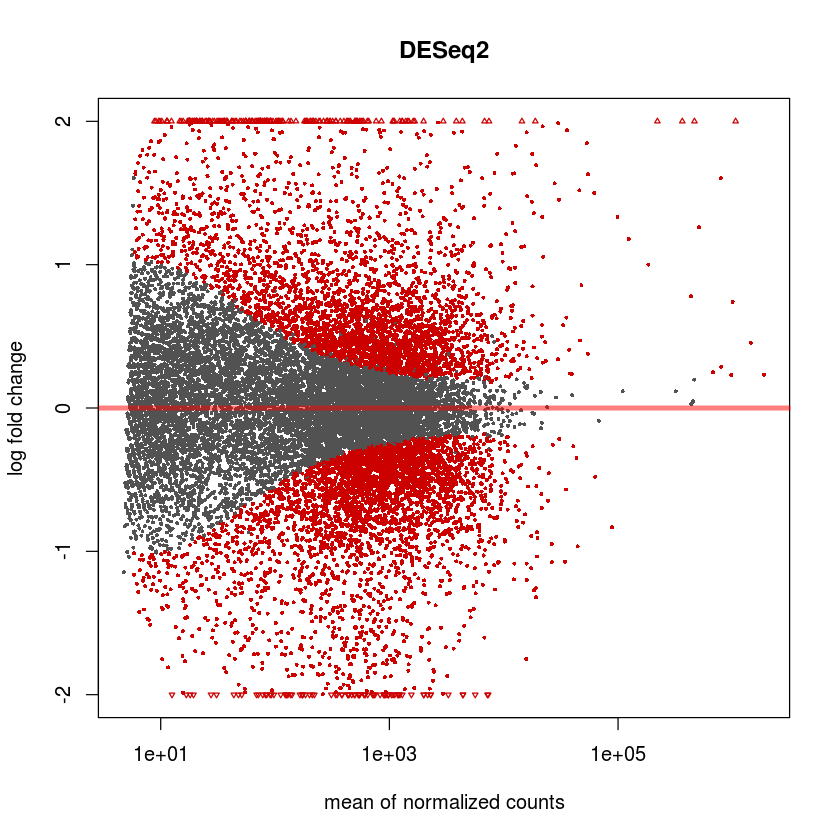

In [9]:
plotMA(res, main="DESeq2", ylim=c(-2,2))

We can also get a more stringent view of our differentially expressed genes by rerunning result on dds with an additional argument alpha. This allows us to be more discerning with our adjusted p value threshold, in this case allowing us to decrease the cutoff to alpha=0.05:

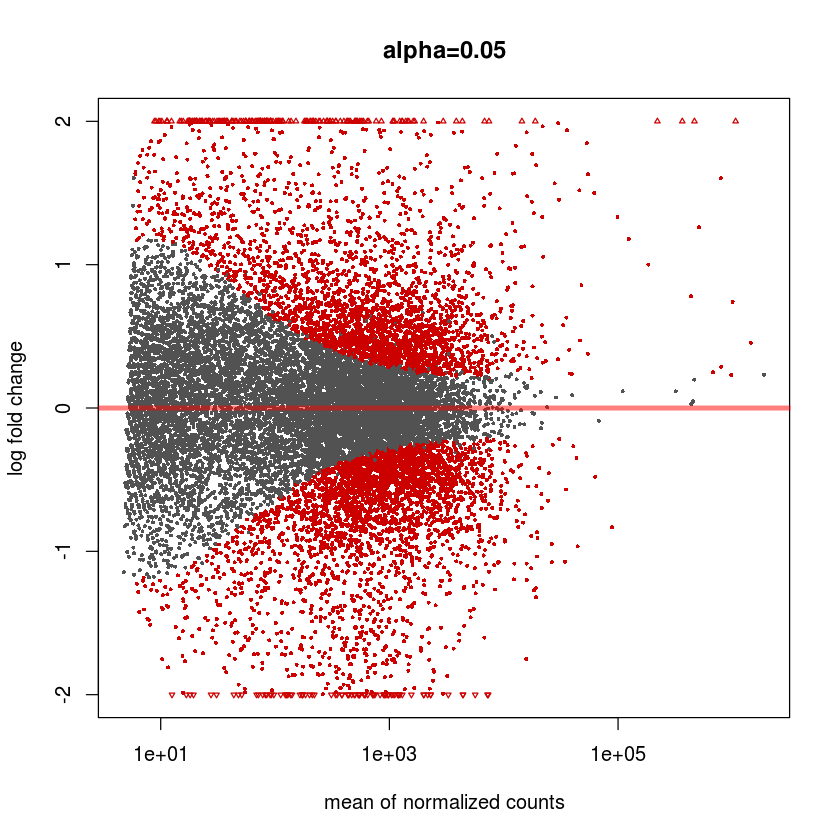

In [10]:
res05 <- results(dds, alpha=0.05)

plotMA(res05, main="alpha=0.05", ylim=c(-2,2))

Let's graph our individual samples using Principle Component Analysis (PCA). This allows us to assess overall variance within our experiment by defining principal components. This plot shows our samples in a 2D plane spanned by their first two principal components. This  is useful for visualizing the overall effect of experimental covariates, in this case shRNA treatment, as well as batch effects that may confound findings. For a more thorough explanation of PCA, please refer to this [notebook]("https://github.com/biom262/biom262-2018/blob/master/Module1_Unix_RNASeq/Tutorials/Intro_to_PCA.ipynb") in the Tutorials folder.

$y
[1] "PC2: 1% variance"

attr(,"class")
[1] "labels"

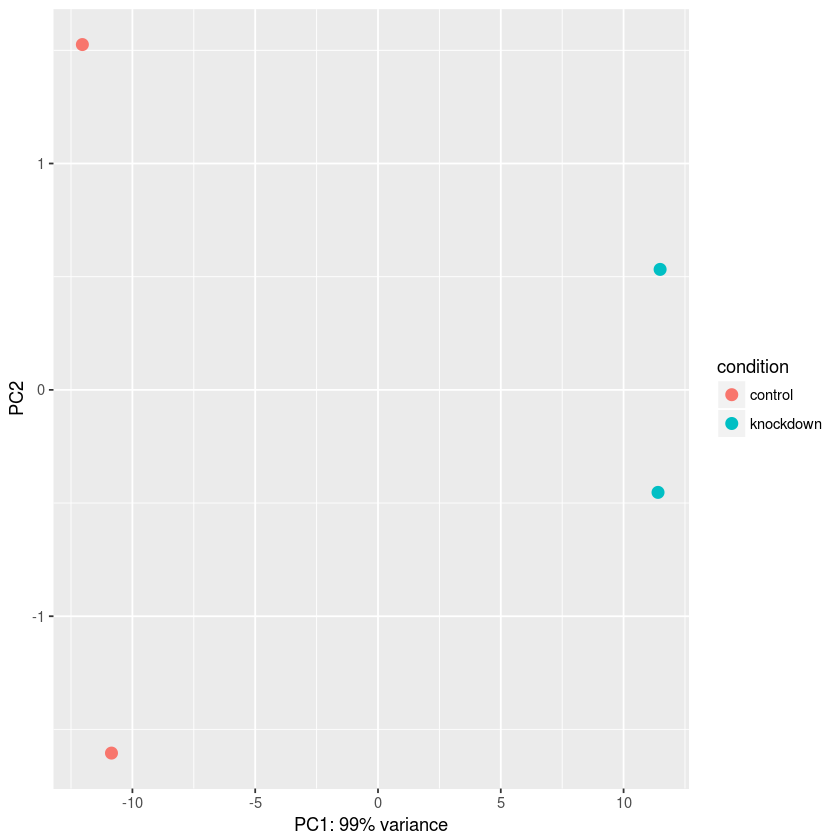

In [11]:
rld <- rlog(dds)
vsd <- varianceStabilizingTransformation(dds)

data <- plotPCA(rld, intgroup="condition", returnData=TRUE)
percentVar <- round(100 * attr(data, "percentVar"))
ggplot(data, aes(PC1, PC2, color=condition)) +
    geom_point(size=3) +
    xlab(paste0("PC1: ",percentVar[1],"% variance")) 
    ylab(paste0("PC2: ",percentVar[2],"% variance"))

As we can see, 99% of variance at the gene level is attibutable to PC1, along which our experimental conditions cluster separately. Thus, we have reasonably high confidence that out treatment is the main source of variance in our experiment. 

Similarly, this can also be visualized via heatmap, which summarizes sample-to-sample similarities via hierarchical clustering:

Warning message in plot.window(...):
“"clustering_distance_rows" is not a graphical parameter”Warning message in plot.window(...):
“"clustering_distance_cols" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"clustering_distance_rows" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"clustering_distance_cols" is not a graphical parameter”Warning message in title(...):
“"clustering_distance_rows" is not a graphical parameter”Warning message in title(...):
“"clustering_distance_cols" is not a graphical parameter”

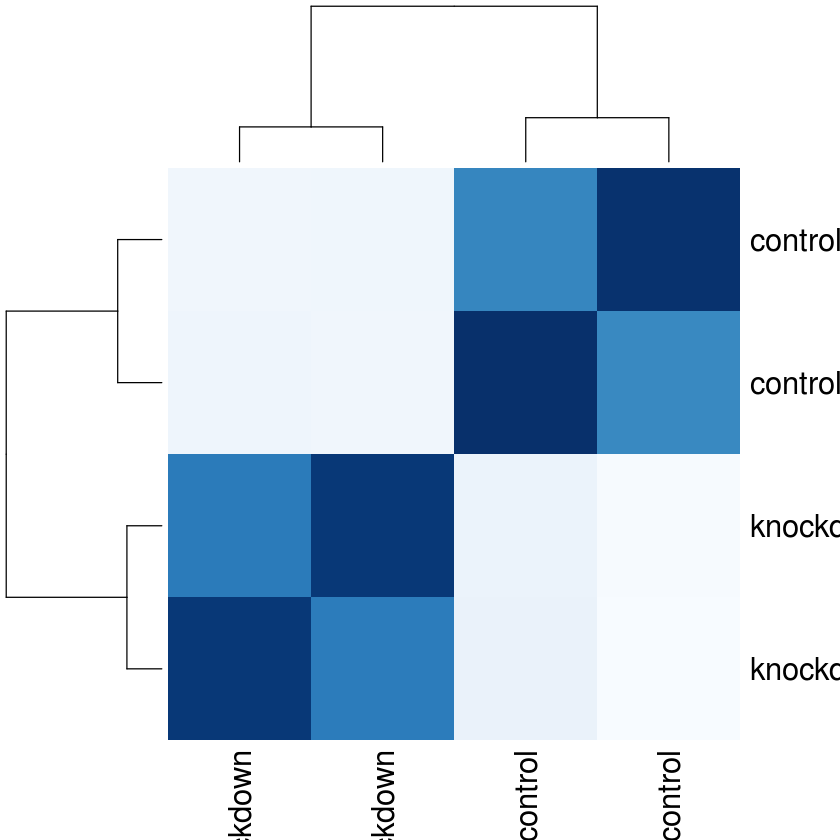

In [12]:
sampleDists <- dist(t(assay(rld)))


sampleDistMatrix <- as.matrix(sampleDists)

rownames(sampleDistMatrix) <- paste(rld$condition)

colnames(sampleDistMatrix) <- paste(rld$condition)

colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)

heatmap(sampleDistMatrix,
clustering_distance_rows=sampleDists,
clustering_distance_cols=sampleDists,
col=colors)